# word2vec

- [word2vec](https://arxiv.org/pdf/1301.3781.pdf) is a package developed by Google in 2013

- 2 types of model with different input and output for a fixed window size

    - CBOW: given context words, predict a center word

    - skip-gram: given a center word, predict context words


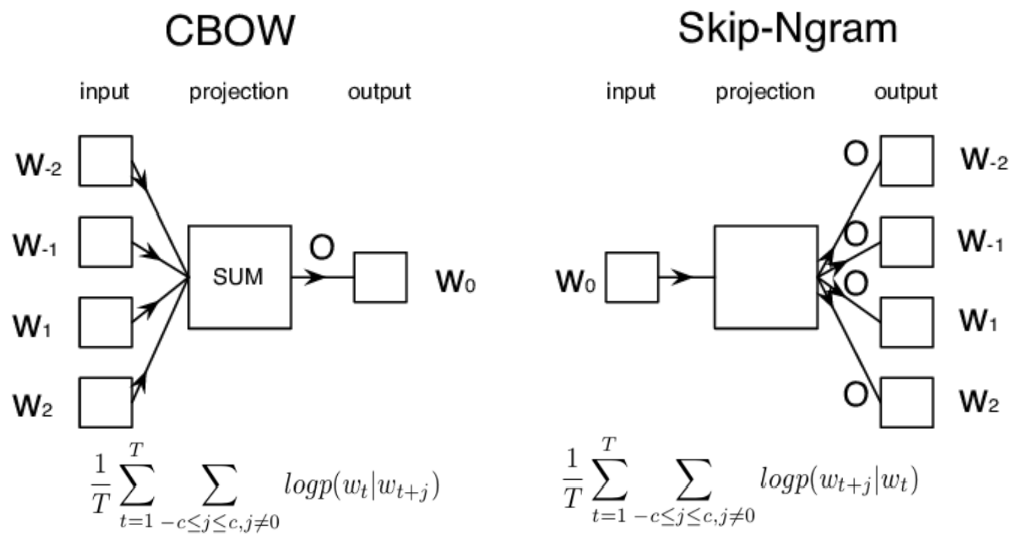

## Skip-gram: multi-class classification

- multi-class classification: predict the probabilities of a word being a context for a center word.

    $$
    P(c|w)=\text{softmax}(\left \langle c \right \rangle^T[w])
    $$

    the predicted context word is the class of highest probability from $|V|$ class

**Notation**

- $n$: number of words in corpus $\mathcal{C}$. can be billion.

- $|\mathcal{V}|$: vocabulary size

- $N$: number of word-context pairs in training set $\mathcal{D}$

hyperparameters

- $L$: maximum window size. 

- $d$: embedding size

learnable parameters

- $W \in \mathbb{R}^{|\mathcal{V}| \times d}$: embedding matrix

- $C \in \mathbb{R}^{d \times |\mathcal{V}|}$: context matrix


data

- $\mathcal{C}$: a corpus of sentences, consists of $n$ observed words. $w_1, w_2, ..., w_n$

- $\mathcal{D} \subseteq (\mathcal{V} \times \mathcal{V})$: a training set containing $N < 2nL$ word-context pairs, word is one-hot encoding data $X$ , context is ground truth label $Y$, either index or one-hot encoding depends on implementation. 

- $\mathcal{V}$: a vocabulary of $|\mathcal{V}|$ unique words

Example sentence "The quick brown fox jumps over the lazy dog", window size = 2

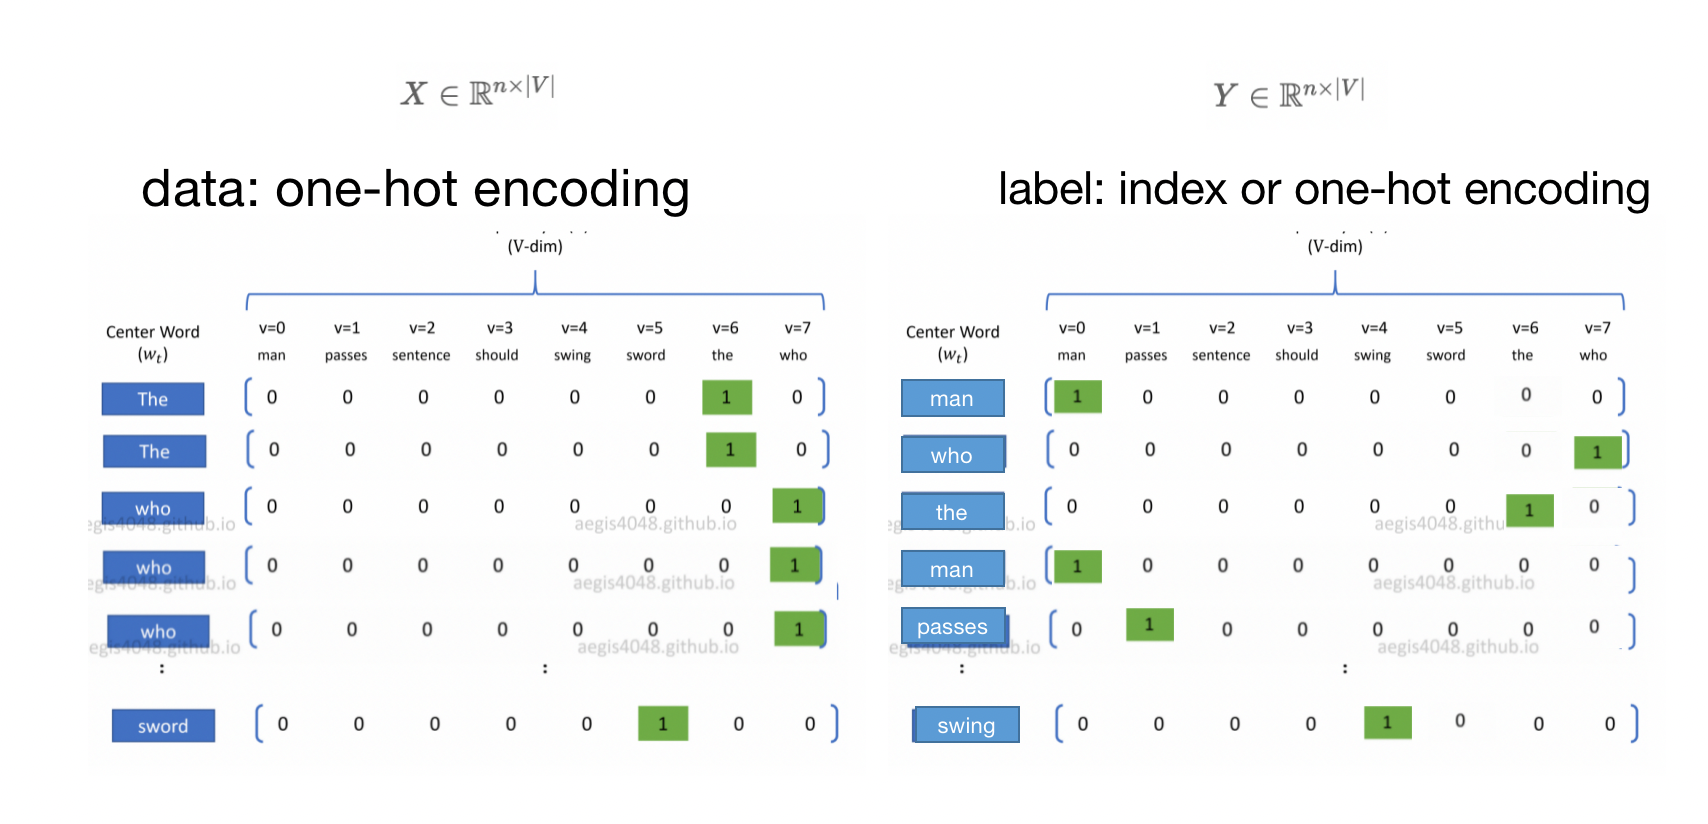

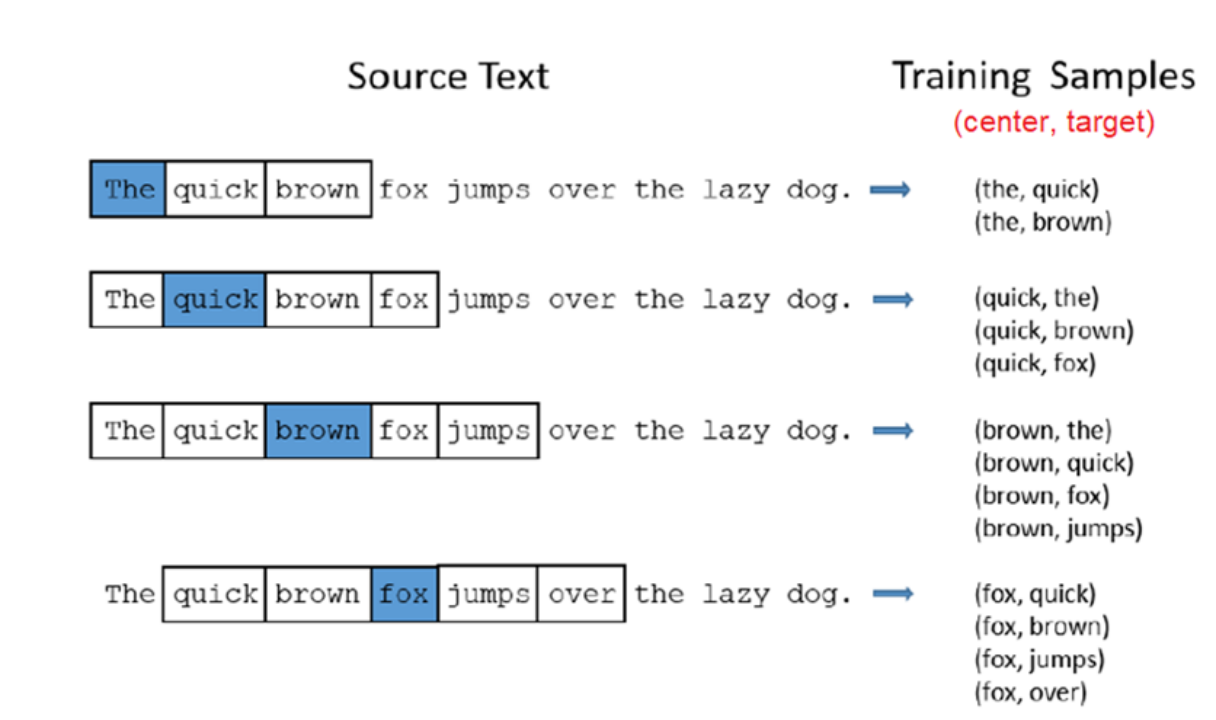

### architecture: MLP + softmax

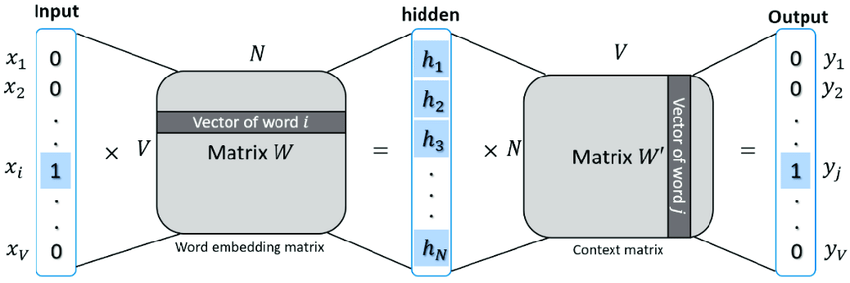

- input layer $X \in \mathbb{R}^{N \times |V|}$: each row is a one-hot encoding vector $X_i^T \in \mathbb{R}^{|V|}$

$$X$$

- embedding layer $H \in \mathbb{R}^{N \times d}$: $W$ is embedding matrix 

$$
H = XW + b_1
$$

- output layer $Y \in \mathbb{R}^{N \times |V|}$: $C$ is context matrix

$$
Y = \text{softmax}(HC + b_2)
$$

softmax convert entries in output vector $y \in \mathbb{R}^{|V|}$ to range [0, 1] and sum up to 1, thus represent a probability distribution over vocabulary,

the entry of highest probability is the context word most likely to occur given center word

### objective: cross-entropy loss

for multi-class classification of $|V|$ classes, label $y_i \in \{0, ..., |V|-1\}$. 

$$
W, C=\underset{W, C}{\arg\min} - \sum_{i=1}^N \sum_{j=1}^{|V|} \left [y_{i}\ln([p_i]_j)+(1-y_{i})\ln(1-[p_i]_j) \right ]
$$

$[p_i]_j \in [0, 1]$ is jth entry of predicted label for ith sample $p_i \in \mathbb{R}^{|V|}$

$y_i$ is ground truth label

## SGNS: binary classification

- Skip-gram is inefficient when **vocabulary size is large**, bc computing softmax involves normalization term that sum over all vocabulary words.

- SGNS (skip-gram with negative sampling) is more efficient, bc **binary classification use sigmoid** function as activation rather than softmax

### model: logistic regression

- finding word embeddings is a **binary classification** task

    - 1: positive sample, a word-context pair **occurring together**
    
    - 0: negative sample, a word-context pair **rarely** occurring together
    

- **binary logistic model**: label $\mathcal{Y}\in \left\{0, 1\right\}$

    probability that word $w$ and context $c$ **occur together** is sigmoid of dot product of word embedding and context embedding

    $$
    P(y=1|w, c) = \sigma (\left \langle c \right \rangle^T[w])
    $$

- why dot product?

    idea: words that occur together have high cosine similarity, not occur together have low cosine similarity in embedding space

    since cosine similarity is just a normalized version of dot product, we can just keep the dot product

    this embedding is isometric: **cosine similarity** reflects word similarity

**Notation**

- $n$: number of words in corpus $\mathcal{C}$

- $|V|$: vocabulary size

- $N$: number of word-context pairs in training set $\mathcal{D}$

hyperparameters

- $L$: maximum window size. contexts for an observed word $w_i$ are the words surrounding $w_i$ in an $L$-sized symmetric window, including the previous $L$ words and next $L$ words. window will slide over a sentence from start to end to create training data and labels. window size is chosen randomly in dataset construction with a maximum limit.

    $$
    w_{i-L},..., w_{i-1}, \text{(center word)}, w_{i+1},..., w_{i+L}
    $$

- $k$: number of negative samples per positive sample

- $d$: embedding size

learnable parameters

- $W \in \mathbb{R}^{|\mathcal{V}|\times d}$: word embedding matrix

- $C \in \mathbb{R}^{|\mathcal{V}|\times d}$: context embedding matrix


data

- $\mathcal{C}$: a corpus of $n$ words

- $\mathcal{D} \subseteq (\mathcal{V} \times \mathcal{V} \times \left \{ 0,1 \right \} )$: a training set containing $N$ word-context-label pair. 

    row dim is not deterministic $\in [(1+k)n, 2L(1+k)n]$
    
    column dim is 3: 1st column is **word**, 2nd column is **context**, 3rd column is **label**. word, context are all represented as index.

- $\mathcal{V}$: a vocabulary of $|\mathcal{V}|$ unique words

### training set 

In [6]:
from IPython.display import Image 
url='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*QY24eIiYmZXkSBYgxJIxfA.png'
Image(url=url, width=500, height=600)

### architecture: MLP + sigmoid

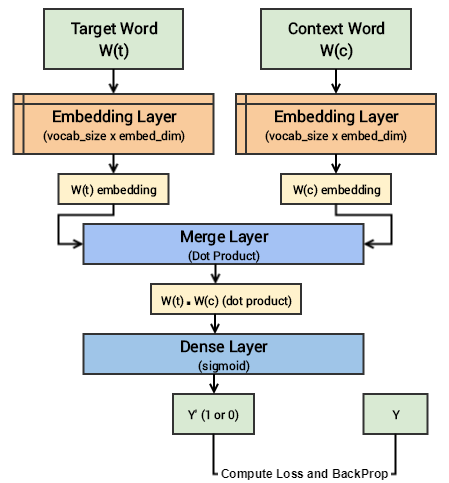

- 2 subnetworks

    - word embedding layer $H_w \in \mathbb{R}^{N \times d}$:  $H_w = X_w W + b_w$

        input is word indices $X_w \in \mathbb{R}^{N}$, $W\in \mathbb{R}^{|V| \times d}$ is word embedding matrix 
    
    - context embedding layer $H_c \in \mathbb{R}^{N \times d}$:  $H_c = X_c C + b_c$

        input is context indices (pos/neg) $X_c \in \mathbb{R}^{N}$, $C\in \mathbb{R}^{|V| \times d}$ is context embedding matrix

- merge layer $Z \in \mathbb{R}^{N}$: dot product of word embedding and context embedding

    $$
    Z = \begin{bmatrix}
    C_1^TW_1 \\
    C_2^TW_2  \\
    \vdots   \\
    C_N^TW_N  \\
    \end{bmatrix}
    $$

- output layer $Y \in \mathbb{R}^{N}$: 

    $$
    Y = \sigma(Z)
    $$

### algorithm

1. make training set:

    for each word $w$ in corpus $\mathcal{C}$:

    form a skip-gram seq around $w$ with window size at most $L$
    
    $$c_1, c_2, ..., c_i, w, c_{i+1}, c_{i+2},...,c_m$$
    
    for each $c$ in the skip-gram ($1 \leq j \leq n$)
    
    - positive sampling: add tuple $(w, c, 1)$ to $\mathbb{D}$.
        
    - negative sampling: randomly sample $k$ words from vocabulary $\mathcal{V}$, add k tuples $(w, c', 0)$ to $\mathbb{D}$.

2. input word, context, labels to MLP, output predicted labels.
 
3. minimize loss

    $$
    W, C \leftarrow \arg\min_{W,C} -\left ( \sum_{(w,c,1)\in \mathbb{D}} \ln[\sigma(\left \langle c \right \rangle^T[w])]\right )-\frac{1}{k}\left ( \sum_{(w,c,0)\in \mathbb{D}} \ln[\sigma(-\left \langle c \right \rangle^T[w])]\right )
    $$

4. discard context embeddings $C$ and use $W$ as word embeddings

### objective: binary cross-entropy loss (NLL or MLE)

interpretation:

- maximize probability of word-context pairs (similar words) occurs together and randomly sampled "negative" word-context pairs (dissimilar) don't occur together

- observed word-context pairs have **similar embeddings**, while unobserved pairs have dissimilar embedding

- words that appear in similar contexts should have similar embeddings

**Binary cross entropy loss**

$$
\begin{align}
&\min_{[w], \left \langle c \right \rangle} \sum_{(w,c,y)\in \mathbb{D}, y\in \left\{0, 1\right\}}L_{CE}(\sigma(\left \langle c \right \rangle^T[w]), y)\\[1em]
&\min_{[w], \left \langle c \right \rangle} \sum_{(w,c,y)\in \mathbb{D}} -y\ln[\sigma(\left \langle c \right \rangle^T[w])]-(1-y)\left ( \ln[\sigma(-\left \langle c \right \rangle^T[w])]\right )
\\[1em]
&\text{Take y = 0 or 1 cancel out some terms}\\[1em]
&\min_{[w], \left \langle c \right \rangle} -\left ( \sum_{(w,c,1)\in \mathbb{D}} \ln[\sigma(\left \langle c \right \rangle^T[w])]\right )-\frac{1}{k}\left ( \sum_{(w,c,0)\in \mathbb{D}} \ln[\sigma(-\left \langle c \right \rangle^T[w])]\right )
\end{align}
$$

**maximum likelihood estimation (mle)**:

- assumption: each data point in $\mathbb{D}$ is i.i.d (independently identically distributed)

    $$
    \max_{W,C}\left ( \prod _{(w,c,1)\in \mathbb{D}} \mathbb{P}[\text{w and c occur together}]\right ) \left ( \prod _{(w,c,0)\in \mathbb{D}} \mathbb{P}[\text{w and c don't occur together}]\right )\\[1em]
    \max_{W,C}\left ( \prod _{(w,c,1)\in \mathbb{D}} \mathbb{P}(y=1|w, c\right ) \left ( \prod _{(w,c,0)\in \mathbb{D}} \mathbb{P}(y=0|w, c)\right )
    $$


- plug in logistic model

$$
=\max_{[w], \left \langle c \right \rangle} \left ( \prod _{(w,c,1)\in \mathbb{D}} \sigma(\left \langle c \right \rangle ^T[w]) \right )\left ( \prod _{(w,c,0)\in \mathbb{D}} 1-\sigma(\left \langle c \right \rangle ^T[w]) \right )
$$


- Given $1-\sigma(x)=\sigma(-x)$

    $$
    =\max_{[w], \left \langle c \right \rangle}  \left ( \prod _{(w,c,1)\in \mathbb{D}} \sigma(\left \langle c \right \rangle ^T[w]) \right )\left ( \prod _{(w,c,0)\in \mathbb{D}} \sigma(-\left \langle c \right \rangle ^T[w]) \right )
    $$

**negative log likelihood**

- take log for numerical stability: as more and more probabilities are multiplied together, products of probabilities will become extremely small, due to rounding error, products may zero out 归零

    $$
    \Leftrightarrow \max_{[w], \left \langle c \right \rangle} \left ( \sum_{(w,c,1)\in \mathbb{D}} \ln[\sigma(\left \langle c \right \rangle^T[w])]\right )+\left ( \sum_{(w,c,0)\in \mathbb{D}} \ln[\sigma(-\left \langle c \right \rangle^T[w])]\right )
    $$

- by convention, multiply -1 to change from a maximization to a minimization problem

    $$
    \Leftrightarrow \min_{[w], \left \langle c \right \rangle} -\left ( \sum_{(w,c,1)\in \mathbb{D}} \ln[\sigma(\left \langle c \right \rangle^T[w])]\right )-\left ( \sum_{(w,c,0)\in \mathbb{D}} \ln[\sigma(-\left \langle c \right \rangle^T[w])]\right )
    $$


- scaling negative samples term by $\frac{1}{k}$ 

    $$
    \Leftrightarrow \min_{[w], \left \langle c \right \rangle} -\left ( \sum_{(w,c,1)\in \mathbb{D}} \ln[\sigma(\left \langle c \right \rangle^T[w])]\right )-\frac{1}{k}\left ( \sum_{(w,c,0)\in \mathbb{D}} \ln[\sigma(-\left \langle c \right \rangle^T[w])]\right )
    $$